# Part 3 - Analysis

After running the simulations, let's see what information we can get out of it. The primary thing we are interested is the absolute binding free energy (ABFE) of ligand binding. What funnel metadynamics (fun-metaD) fundamentally does is deposit bias along a set of reaction coordinates (aka collective variables or CVs), forcing the ligand to unbind, explore the solvent phase, and eventually allow it to rebind back. 

Since we can track the amount of bias deposited along these CVs, we can construct a free energy surface by inverting the accumulated bias and projecting it along the CVs. To recover the ABFE, we can look at the projection CV and find the difference in free energy between the bound phase and the unbound/solvent phase.

It is important to remember that we aren't truly samply the unbound phase, instead we limit the exploration of the ligand to a small volume at the 'tip' of the funnel. Correction for the loss of rotational and translational freedom of the ligand in the unbound phase due to the funnel restraints are
calculated as described in [Rhys *et al* 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7467642/).

To determine whether the simulation has converged or not, we will have a look at the time evolution of the CVs and the free energy estimate.

Let's start with importing the relevant libraries.

In [1]:
import BioSimSpace as BSS
import numpy as np
import matplotlib.pyplot as plt


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



We will need the CV definitions that we used in running the fun-metaD simulation to reconstruct the free energy surface using PLUMED. We begin with loading the system.

In [2]:
system = BSS.IO.readMolecules("input_files/0_run/fun-metaD/openmm.*7")

Now we redefine p0 and p1 points.

In [3]:
p0, p1 = BSS.Metadynamics.CollectiveVariable.makeFunnel(system)

Write the CV definitions as you put them into the BSS script.

In [4]:
new_upper_bound = BSS.Metadynamics.Bound(3.5 * BSS.Units.Length.nanometer)
cv = BSS.Metadynamics.CollectiveVariable.Funnel(p0, p1, upper_bound=new_upper_bound)

Use the CV definitions to reconstruct the protocol.

In [5]:
protocol = BSS.Protocol.Metadynamics(cv)

Create a PLUMED process that will run the analysis

In [6]:
plumed = BSS.Process.Plumed(work_dir="input_files/0_run/fun-metaD/")
config = plumed.createConfig(system, protocol)

### Part 3.1 - CVs vs time

Now we can plot the CVs across time. The first column, index 0, is the projection CV and the second column, index 1, is the extent CV.

We can see that the extent CV is more or less diffusive - the ligand is rapidly exploring across the entire range of allowed CV values. 

The projection variable is much less diffusive, where the ligand is freely exploring the unbound phase, from about 2.0 nm to 3.5 nm, but is far slower in the bound phase. This is understandable, the ligand interacts with protein and is slowed down in its exploration.

One of the most important things in determining whether the fun-metaD simulation has converged is the return of the ligand from the solvent back into the binding site. Looking at the projection CV, we see the ligand at start is around 1.0-1.2 nm from the origin. It unbinds and returns to that value multiple times, especially clearly at around 35-40 ns. At least one rebinding event is needed to construct an accurate FES.

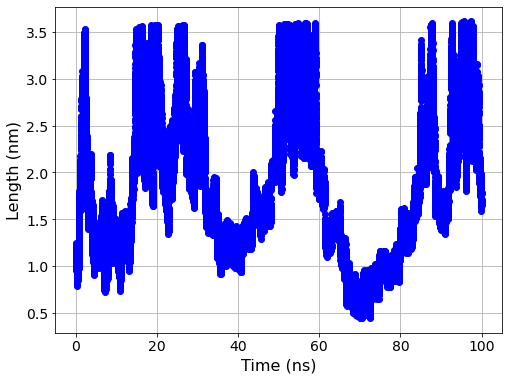

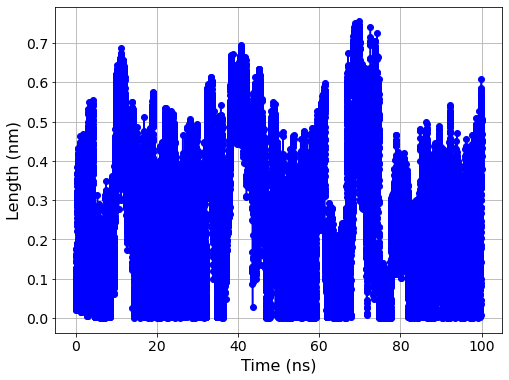

In [7]:
BSS.Notebook.plot(
    x=plumed.getTime(time_series=True),
    y=plumed.getCollectiveVariable(0, time_series=True),
)
BSS.Notebook.plot(
    x=plumed.getTime(time_series=True),
    y=plumed.getCollectiveVariable(1, time_series=True),
)

### Part 3.2 - 2D free energy surface

Now let's have a look at the free energy surfaces. Here we plot the 2D surface.

The 0th index in the `free_nrg` matrix contains the projection values, 1st index - the extent values and the 2nd index has the free energy values, in kJ/mol.

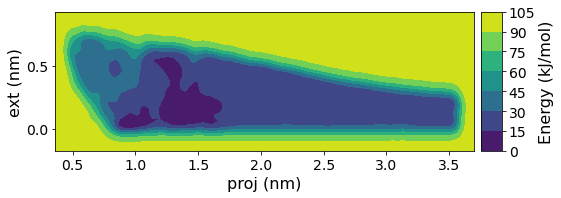

In [8]:
free_nrg = plumed.getFreeEnergy()
BSS.Notebook.plotContour(
    free_nrg[0], free_nrg[1], free_nrg[2], xlabel="proj (nm)", ylabel="ext (nm)"
)

### Part 3.3 - 1D FES

We can integrate the FE values for each CV. The smoothness of the FES in the solvent phase (last 0.5 nm of projection CV) is another indicator of convergence. 

Note - the extent CV shouldn't have any free energy below 0.0 nm, but because the bias potential is Gaussian-shaped, the Gaussian 'tails' overspill to non-real values.

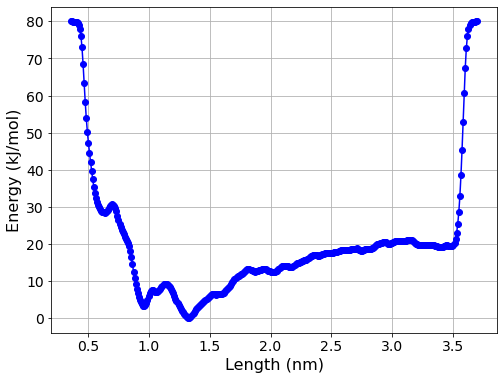

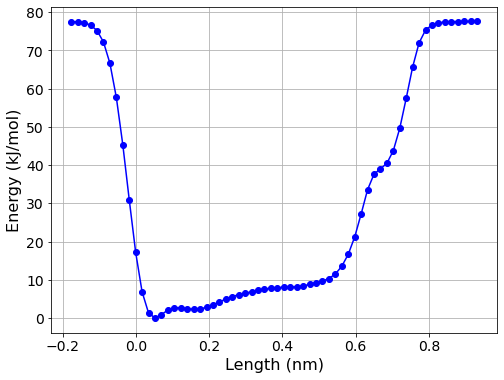

In [9]:
# the projection CV vs FE
free_nrg0 = plumed.getFreeEnergy(0, kt=2.49 * BSS.Units.Energy.kt)
BSS.Notebook.plot(free_nrg0[0], free_nrg0[1])

# the extent CV vs FE
free_nrg1 = plumed.getFreeEnergy(1, kt=2.49 * BSS.Units.Energy.kt)
BSS.Notebook.plot(free_nrg1[0], free_nrg1[1])

### Part 3.4 - Absolute binding free energy

As I mentioned in the beginning of this tutorial, to recover the ABFE, we need to find the difference in free energy between the bound and the unbound/solvent phases. We will use a 1D FES along the projection CV and will add the funnel correction.

In [10]:
funnel_correction = cv.getCorrection().kcal_per_mol()

# the last 0.5 nm of the projection CV are between indices -75 to -25
free_nrg_floats = [i.kj_per_mol().magnitude() for i in free_nrg0[1][-75:-25]]

estimate = -(np.mean(free_nrg_floats) / 4.184 + funnel_correction.magnitude())

print(f"the funnel correction = {funnel_correction}")
print(f"the ABFE estimate = {estimate:.2f} kcal/mol")

the funnel correction = -3.2045 kcal/mol
the ABFE estimate = -1.57 kcal/mol


### Part 3.5 - $\Delta$G vs time

Finally, we need to look at the time evolution of the free energy estimate. We can get the 1D FES every 1 ns, and since we recorded the CV every 2 ps, we select a 500 step stride. 

In [11]:
free_nrg_series = plumed.getFreeEnergy(0, stride=500)

Now let's find the estimate at every 1 ns of the simulation.

In [12]:
funnel_correction = cv.getCorrection().kcal_per_mol()

estimates_list = []
for item in range(np.shape(free_nrg_series)[0]):
    free_nrg_floats = [i.magnitude() for i in free_nrg_series[item][1][-75:-25]]
    estimate = -(np.mean(free_nrg_floats) / 4.184 + funnel_correction.magnitude())
    estimates_list.append(estimate)

One important aspect of fun-metaD, and all metadynamics simulations, is achieving convergence. If the fun-metaD simulation has fully converged i.e. the free energy surface has been fully explored, then the ABFE estimate should plateau at a certain value.

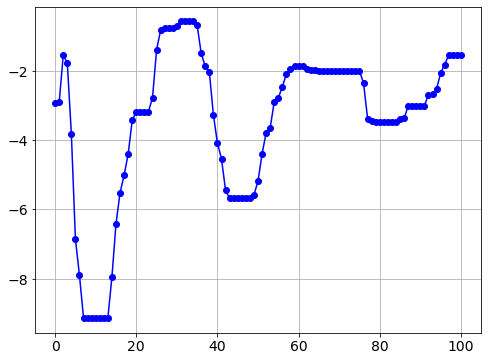

In [13]:
BSS.Notebook.plot(estimates_list)

### Part 3.6 - Multiple repeats

We can see from the plot above that the free energy estimate still fluctuates quite a lot. In practice, I have seen that often you need around 1 microsecond-long simulations to converge the free energy. The estimate never completely plateaus, just oscillates within a 1 kcal/mol range.

In order to get a good error estimate, you should do multiple independent simulations. I've provided the data for 5 repeats. Let's plot them all together, while also estimating the mean of the 5 repeats at each timepoint.

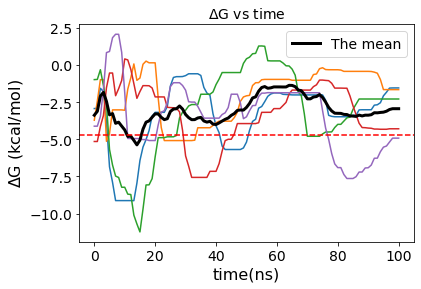

In [16]:
funnel_correction = cv.getCorrection().kcal_per_mol()

plt.title("$\Delta$G vs time")
plt.xlabel("time(ns)")
plt.ylabel("$\Delta$G (kcal/mol)")
all_estimates = []

for run_index in range(0, 5):
    plumed = BSS.Process.Plumed(work_dir=f"input_files/{run_index}_run/fun-metaD/")
    config = plumed.createConfig(system, protocol)

    free_nrg_series = plumed.getFreeEnergy(0, stride=500)

    estimates_list = []
    for item in range(np.shape(free_nrg_series)[0]):
        free_nrg_floats = [i.magnitude() for i in free_nrg_series[item][1][-75:-25]]
        estimate = -(np.mean(free_nrg_floats) / 4.184 + funnel_correction.magnitude())
        estimates_list.append(estimate)

    plt.plot(estimates_list)
    all_estimates.append(estimates_list)

all_estimates = np.array(all_estimates)
mean_estimates = []
for i in range(len(all_estimates[0])):
    mean_estimate = np.mean(all_estimates[:, i])
    mean_estimates.append(mean_estimate)
plt.plot(mean_estimates, linewidth=3, color="black", label="The mean")
exp_affinity = -4.7
plt.axhline(y=exp_affinity, color="red", linestyle="--")
plt.legend()
plt.show()

## Closing thoughts

You can see that each fun-metaD simulation explores the free energy surface very differently. The ABFE estimates diverge immediately and fluctuate wildly. However, the mean of the estimates is quite stable. This indicates that, while each fun-metaD simulation is exploring a different part of the FES at any given point, the full free energy surface is explored quickly. 